In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize 
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [3]:
## DEFINE UNIVERSAL PARAMETERS
RW = 12 * 20

In [4]:
## READ THE DATA FROM EXCEL FILE

data = pd.read_excel("/Users/federicoklinkert/Documents/Columbia University/Fall 2019/IEOR 4742/Shiller Data with Calculated Returns .xls")

## SELECT ONLY RETURNS' COLUMNS
returns = pd.DataFrame(data, columns= ['Unnamed: 11','Unnamed: 12'])
returns.rename(columns={"Unnamed: 11": "Stock Returns", "Unnamed: 12": "Bond Returns"})

## DELETE FIRST 7 ROWS AND LAST ROW TO ONLY HAVE RETURNS
returns = returns.iloc[7:]
returns = returns.iloc[:-1]

## CONVERT INTO A NUMPY MATRIX
returns = returns.as_matrix().transpose()

In [5]:
## CALCULATE THE 20 YEARS MOVING AVERAGE AND STANDARD DEVIATION
MA20y = np.zeros([2,len(returns[0])-RW+1])
SD20y = np.zeros([2,len(returns[0])-RW+1])
corr20y = np.zeros(len(returns[0])-RW+1)

for i in range(len(MA20y[0])):
    a = returns[0][i:i+RW]
    b = returns[1][i:i+RW]
    MA20y[0][i] = np.mean(a)
    MA20y[1][i] = np.mean(b)
    SD20y[0][i] = np.std(a,ddof=1)
    SD20y[1][i] = np.std(b,ddof=1)
    corr20y[i] = pearsonr(a,b)[0]

### Objective Function
#### Minimize: - [wgt x return - (wgt x covariance x wgt) / (2 x risk tolerance)]  | where wgt = portfolio asset weights

*(Since we are minimizing, the objective function is negative)*

In [6]:
def objective(wgt):                         # needed for minimize function below
    tol = 0.3                              # risk tolerance can be changed from conservative to aggressive
    obj = -(np.dot(wgt, ret) - (np.dot(wgt, np.dot(covMat, wgt).flatten())/(2*tol)))     # Objective function
    return obj 

### Constraints
#### Sum of weights = 1

In [7]:
def constraint1(wgt):                        # needed for minimize function below
    cnst1 = wgt[0] + wgt[1] - 1
    return cnst1

#### Specify equality constraint

In [8]:
con1 = {'type': 'eq', 'fun': constraint1}    # needed for minimize function below

### Bounds (No Shorting)

#### weight(i) >= 0

In [9]:
b = (0,None)
bnds = (b,b)

### Optimization Function

In [10]:
weights = np.zeros([2,len(returns[0])-RW+1])


for i in range(len(weights[0])):
    ret = [MA20y[0][i],MA20y[1][i]]
    sd = [SD20y[0][i], SD20y[1][i]]
    sdMat = np.diag(sd)
    corr = [1.0,corr20y[i],corr20y[i],1.0]
    corrMat = np.reshape(corr, (2,2))
    covMat = np.dot(sdMat, np.dot(corrMat, sdMat))
    
    ev = np.linalg.eigvals(corrMat)                   # Eigenvalues of correlation matrix
    if sum(n < 0 for n in ev):                        # If eigenvalues are negative then corrMat NOT PSD
        # print('*** Error: Correlation matrix is NOT Positive Semi-Definite (PSD)  ***')
        print('\033[1;31m*** Error: Correlation matrix is NOT Positive Semi-Definite (PSD)  ***\033[1;m]')
        print()
        print('Eigenvalues =', ev)
        print()
    wgt0 = np.array([1, 0])
       
    solution = minimize(objective,wgt0,method='SLSQP',bounds=bnds,constraints=con1)
    weights[0][i] = solution["x"][0]
    weights[1][i] = solution["x"][1]

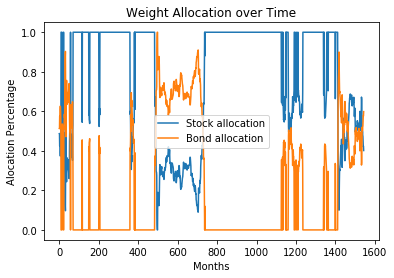

In [11]:
## SHOW WEIGHT ALLOCATION OVER TIME
plt.plot(weights[0], label = "Stock allocation")
plt.plot(weights[1], label = "Bond allocation")
plt.legend(loc="best")
plt.title("Weight Allocation over Time")
plt.xlabel("Months")
plt.ylabel("Alocation Percentage")
plt.show()

## Back Test

In [12]:
## CALCULATE MONTHLY RETURNS OF PORTFOLIOS
backtest = returns[0][RW:]*weights[0][:-1]+returns[1][RW:]*weights[1][:-1]
P6040 = returns[0][RW:]*0.6+returns[1][RW:]*0.4
best_possible_results = np.maximum(returns[0][RW:],returns[1][RW:])

In [13]:
## CALCULATE CUMULATIVE RETURNS FOR ALL STRATEGIES
backtest_cr = np.ones(len(backtest)+1)
stocks_cr = np.ones(len(backtest_cr))
bonds_cr = np.ones(len(backtest_cr))
p6040_cr = np.ones(len(backtest_cr))
bpr_cr = np.ones(len(backtest_cr))

for i in range(len(backtest)):
    backtest_cr[i+1] = backtest_cr[i]*((backtest[i])+1)
    stocks_cr[i+1] = stocks_cr[i]*((returns[0][(RW+i)])+1)
    bonds_cr[i+1] = bonds_cr[i]*((returns[1][(RW+i)])+1)
    p6040_cr[i+1] = p6040_cr[i]*((P6040[i])+1)
    bpr_cr[i+1] = bpr_cr[i]*((best_possible_results[i])+1)

In [18]:
## CALCULATE GEOMETRIC MEAN AND STANDARD DEVIATION OF PORTFOLIOS
MEAN_P = (np.power(backtest_cr[len(backtest_cr)-1],1/(len(backtest_cr)-1))-1)*100
SD_P = np.std(backtest*100,ddof=1)

MEAN_S = (np.power(stocks_cr[len(backtest_cr)-1],1/(len(backtest_cr)-1))-1)*100
SD_S = np.std(returns[0][RW:]*100,ddof=1)

MEAN_B = (np.power(bonds_cr[len(backtest_cr)-1],1/(len(backtest_cr)-1))-1)*100
SD_B = np.std(returns[1][RW:]*100,ddof=1)

MEAN_P6040 = (np.power(p6040_cr[len(backtest_cr)-1],1/(len(backtest_cr)-1))-1)*100
SD_P6040 = np.std(P6040*100,ddof=1)

MEAN_BPR = (np.power(bpr_cr[len(backtest_cr)-1],1/(len(backtest_cr)-1))-1)*100
SD_BPR = np.std(best_possible_results*100,ddof=1)

In [19]:
## GET ALL RESULTS IN A MATRIX
results = [[MEAN_S, SD_S, MEAN_S/SD_S],[MEAN_B, SD_B,MEAN_B/SD_B],
           [MEAN_P,SD_P,MEAN_P/SD_P],[MEAN_P6040,SD_P6040,MEAN_P6040/SD_P6040],
          [MEAN_BPR,SD_BPR,MEAN_BPR/SD_BPR]]

In [20]:
## GET THE FINAL RESULT IN A PANDAS DATAFRAME FOR VISUALIZATION
final_result = pd.DataFrame(results, columns = ["Mean","Std. Dev.","Sharpe Ratio"])
final_result.rename(index={0:"Stock",1:"Bonds",2:"Portfolio",3:"60/40 Portfolio",4:"Best Possible Result"},inplace=True)
final_result

,Mean,Std. Dev.,Sharpe Ratio
Stock,0.760732,4.193437,0.181410
Bonds,0.391848,1.335645,0.293377
Portfolio,0.646028,3.092977,0.208869
60/40 Portfolio,0.635712,2.593246,0.245141
Best Possible Result,2.132445,2.729139,0.781362


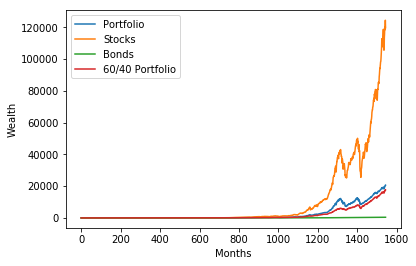

In [21]:
## PLOT CUMULATIVE RETURNS
plt.plot(backtest_cr, label = "Portfolio")
plt.plot(stocks_cr, label = "Stocks")
plt.plot(bonds_cr,label="Bonds")
plt.plot(p6040_cr,label="60/40 Portfolio")
#plt.plot(bpr_plot, label = "Best Possible Portfolio")
plt.legend(loc="best")
plt.xlabel("Months")
plt.ylabel("Wealth")
plt.show()